In [ ]:
f(s) = (p,v)

s = [una matriz de 1(juega negras) o 0 ( juega blancas) entera dependiendo el turno,
     tablero actual piezas negras
     7 turnos antes negras
     talbero actual blancas
     7 turnos antes blancas]
son 17 fotos de tableros 

a = las siguientes posibles jugadas
p = probabilidad de elegir el siguiente a dado el actual estado s
v = es la probabilidad de que el jugador actual gane dado el estado s

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [428]:
class Nodo():
    
    def __init__(self,game,c=1): 
        self.montecarlo_player = game.player
        self.game = game
        self.pasoporaca=0
        self.ganopasando=0
        self.hijos=[]
        self.pos='-1'
        self.c = c        
    
    def select(self):
        if self.pasoporaca==0 or len(self.hijos)==0:
            self.expand()
            k=0
            if len(self.hijos)!=0:
                rnd = randint(0,len(self.hijos)-1)
                winer = self.hijos[rnd].game.simulate()
                if winer == self.montecarlo_player:
                    k=1
                elif winer == "T":
                    k=0
                else:
                    k=-1
                self.hijos[rnd].ganopasando+=k
                self.hijos[rnd].pasoporaca+=1
            else : 
                winer = self.game.simulate()
                if winer == self.montecarlo_player:
                    k=1
                elif winer == "T":
                    k=0
                else:
                    k=-1
                
            self.ganopasando+=k
            self.pasoporaca+=1
            return k
        else:
            mejor_hijo = self.get_best()            
            k = mejor_hijo.select()
            self.ganopasando+= k
            self.pasoporaca+=1
            return k
         
    def expand(self):                
        for m in self.game.moves:
            gc = self.game.clonar()
            gc.move(m)
            hijo = Nodo(gc,self.c)
            hijo.montecarlo_player = self.montecarlo_player
            hijo.pos = f"{self.pos}_{m}"
            self.hijos.append(hijo)        
      
    def get_best(self):
        return sorted(self.hijos,key=lambda i:self.desition_maker(i.ganopasando,i.pasoporaca,self.pasoporaca) )[-1]          
    def desition_maker(self,w,n,N):    
        if n == 0:
            return 50000        
        else:                        
            return w/n + self.c*(np.log(N)/n )**.5        

In [429]:
max_deep=3
width=9
def dibujar(nodo,ax,depth):
    if depth==max_deep or nodo.pasoporaca==0:
        return ax
    
    l = nodo.pos.split("_")   
    
    cantidad_espacios=0
    
    for i,n in enumerate(l):
        if n != '-1':
            cantidad_espacios += width**(max_deep-1-i)*int(n)
    
    xh,yh =cantidad_espacios,max_deep-depth
    xp,yp =cantidad_espacios,max_deep-depth
    if len(l)>1:
        xp,yp = cantidad_espacios-width**(max_deep-1-i)*int(l[-1]),max_deep-depth+1
    
    df = pd.DataFrame({'x':[xh,xp],'y':[yh,yp]})    
    if depth%2!=0:
        ax = df.plot(kind='line',x='x',y='y',ax=ax,c='Orange')
    else:
        ax = df.plot(kind='line',x='x',y='y',ax=ax,c='Blue')
    
    if len(l)>1:
        ax.text(x=xh+(xp-xh)/2, y=yh+(yp-yh)/2, s=f"{nodo.ganopasando}/{nodo.pasoporaca}", alpha=0.7, color='#334f8d')
    
    ax = df.plot(kind='scatter',x='x',y='y',s=3,ax=ax,c='r',legend=None,figsize=(12,6)   ) 
    ax.get_legend().remove()
    ax.set_xlim(-1,width**(max_deep-1)+1)
    for h in nodo.hijos:
        ax = dibujar(h,ax,depth+1)
    return ax
        

In [430]:
from random import sample
class Tateti():
    def __init__(self):
        self.player="O"
        #uso la disposiion del pad de numeros 
        #7 8 9
        #4 5 6 === 123456789
        #1 2 3
        self.tablero="#,#,#,#,#,#,#,#,#".split(",")
        self.moves = set([i for i in range(9)])
        self.turnos = 0
        self.end=False
        self.swap = {'X':'O','O':'X'}
        pass
    def gano(self):
        mapa = self.tablero
        gano = False
        #horizontales
        gano = gano or (mapa[6] == mapa[7] == mapa[8] != "#")
        gano = gano or  (mapa[3] == mapa[4] == mapa[5] != "#")
        gano = gano or (mapa[0] == mapa[1] == mapa[2] != "#")
        #verticales
        gano = gano or (mapa[2] == mapa[5] == mapa[8] != "#")
        gano = gano or (mapa[1] == mapa[4] == mapa[7] != "#")
        gano = gano or (mapa[0] == mapa[3] == mapa[6] != "#")
        #diagonales
        gano = gano or (mapa[0] == mapa[4] == mapa[8] != "#")
        gano = gano or (mapa[2] == mapa[4] == mapa[6] != "#")        
        return gano
    
    def show(self):
        mapa = self.tablero
        print(mapa[6:])
        print(mapa[3:6])
        print(mapa[:3])
    
    def move(self,x):
        if self.end or len(self.moves)==0:
            return        
        if x in self.moves:
            self.tablero[x]=self.player
            self.moves.remove(x)
            
            if self.gano():
                self.end=True
                self.moves=set()
                return
            else:            
                self.player=self.swap[self.player]        

            if len(self.moves)==0:
                self.end=True
                self.player="T"
        return 
    
    def get_winner(self):
        if self.end:
            return self.player
        else:
            return "#"
    
    def clonar(self):
        clon = Tateti()
        clon.player = self.player
        clon.tablero = self.tablero.copy()
        clon.moves = self.moves.copy()
        clon.turnos = self.turnos
        clon.end = self.end
        return clon
       
    def simulate(self):
        clon = self.clonar()                
        while(not clon.end):            
            m = sample(clon.moves ,1)[0]
            clon.move(m)        
        return clon.player
            

In [455]:
max_deep=3
CONSTANTE_LOCA=2

In [456]:
from random import randint

In [493]:
g = Tateti()

In [469]:
r = Nodo(g,2)
for i in range(500):
    r.select()

In [470]:
r.pasoporaca
l = list(map(lambda i:r.desition_maker(i.ganopasando,i.pasoporaca,r.pasoporaca),r.hijos)   )
for i,z in enumerate(l):
    h = r.hijos[i]
    print(h.ganopasando,h.pasoporaca,z)

24 63 1.009107052958658
-3 18 1.0085031176077581
30 72 1.0042515588038792
9 40 1.0133278568224133
67 119 1.0200748680676393
-2 22 0.9720719743821357
11 44 1.0016411195403268
7 38 0.9930178417612702
41 84 1.032093141558556


In [514]:
r.montecarlo_player

AttributeError: 'str' object has no attribute 'montecarlo_player'

In [525]:
r = next_pos(g,500,100,DEBUG=True)
#print(r.pos.split("_")[-1])

-79 123 0
-38 127 1
-42 127 3
-81 123 7


In [ ]:
r

In [500]:
r = next_pos(g,5000,20,DEBUG=True)
g.move(int(r))
g.show()

93 793 0
347 1001 1
446 1078 3
917 1424 5
-7 704 7
['O', '#', 'X']
['#', 'O', 'O']
['#', '#', 'X']


In [423]:
g.move(5)
g.show()

['#', '#', '#']
['#', 'X', 'O']
['#', '#', '#']


In [515]:
def next_pos(game,iters,c,DEBUG=False):
    r = Nodo(game,c)
    for i in range(iters):
        r.select()
    
    mejor_jugada = "NOSE"
    puntos = 0
    for h in r.hijos:                        
        tmp = h.pasoporaca
        if DEBUG:
            print(h.ganopasando,h.pasoporaca,h.pos.split("_")[-1])        
        #print(tmp,h.pos.split("_")[-1])
        #print()
        #print(h.pos)
        if tmp>puntos:
            mejor_jugada = h.pos.split("_")[-1]
            puntos=tmp
        
    #print(mejor_jugada)
    #dibujar(r,None,0)
    #plt.show()    
    return r

In [197]:
g= Tateti()
g.move(0)
r = Nodo(ITERACIONES,g)
for i in range(1000):
    r.select()
dibujar(r,None,0)
plt.show()

NameError: name 'ITERACIONES' is not defined

In [10]:
[i.ganopasando/i.pasoporaca*100//1 for i in r.hijos]
    

[16.0, 17.0, 89.0, 10.0, 11.0, 0.0, 10.0, 2.0, 10.0]

C:\Users\Matias\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


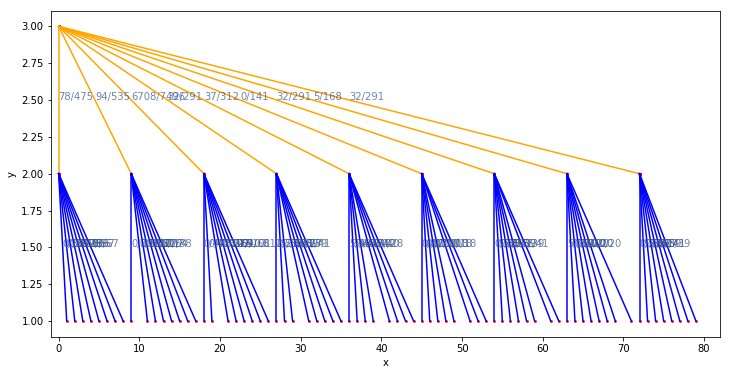

In [9]:
ITERACIONES=10000
r = Nodo(ITERACIONES,Tateti())
for i in range(ITERACIONES):
    r.select()
dibujar(r,None,0)
plt.show()

In [215]:
a = Tateti()
a.move(2)
a.show()

['#', '#', '#']
['#', '#', '#']
['#', '#', 'O']


In [208]:
ITERACIONES=100000
r = Nodo(ITERACIONES,Tateti())
for i in range(ITERACIONES):
    r.select()
#dibujar(r,None,0)
#plt.show()

In [209]:
for i in r.hijos:
    print(i.ganopasando/i.pasoporaca)

0.17102966841186737
0.16903914590747332
0.9901152026332031
0.10126582278481013
0.10979228486646884
0.0
0.10126582278481013
0.025906735751295335
0.10126582278481013
